### Initialise libraries and function

In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

# results_path = "/home/antoniu/Desktop/MFI_git/MFI/results_plot"
# path_data = "/home/antoniu/Desktop/MFI_git/MFI/AlanineDipeptide_pyMFI"

path = "/home/ucecabj/Desktop/pyMFI_git"
os.chdir(path)
print("The path to the MFI library is:", path)

from pyMFI import MFI
from pyMFI import run_plumed
from scipy import interpolate

# path_data = "/home/ucecabj/Desktop/pyMFI_git/DATA_examples/Invernizzi_2D_potential"
path_data = "/home/ucecabj/Desktop/pyMFI_git/MFI_development/external_bias"
os.chdir(path_data)
print("The current path is:", path_data)

The path to the MFI library is: /home/ucecabj/Desktop/pyMFI_git
The current path is: /home/ucecabj/Desktop/pyMFI_git/MFI_development/external_bias


In [2]:
grid_x = np.linspace(-3, 3, 200); 
grid_y = np.linspace(-2.5, 2.5, 400); 
X, Y = np.meshgrid(grid_x, grid_y)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)

# plt.figure(figsize=(5,4)); 
# plt.contourf(X, Y, inve_pot, levels=range(0, 20, 1), cmap='coolwarm')
# plt.xlabel("x"); plt.ylabel("y"); plt.title("Analytical Invernizzi Potential"); plt.colorbar(); plt.show()

2000
(400, 200)
|**************************************************| 100% | Average Mean Force Error: 9.441

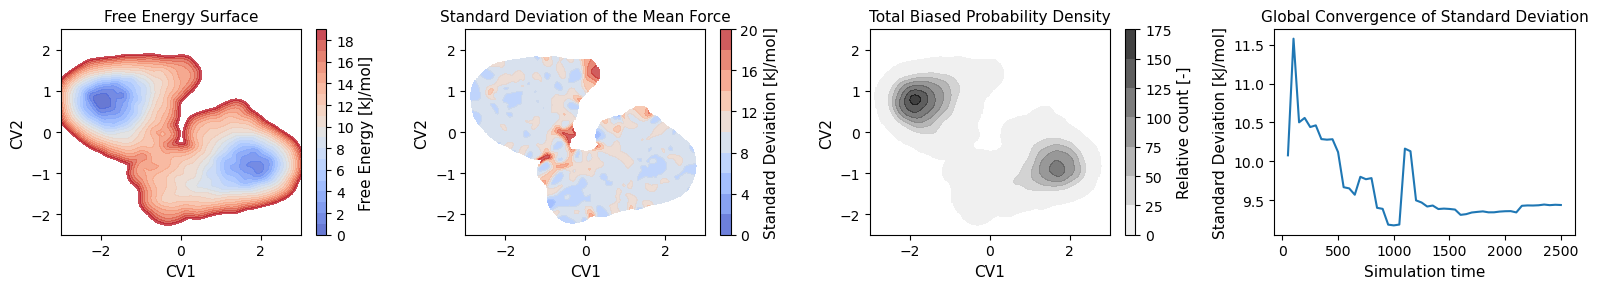

In [3]:
#Run simulation
# run_plumed.run_2D_Invernizzi(simulation_steps=1000000, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=-1, initial_position_y=-1, file_extension="")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_1")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="positioninve_1")

print(len(HILLS))

#COMPUTE Mean force and weight of the simulation
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(
    HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((0.12,0.12)), kT = 1, nhills=int(len(HILLS)/2),
    min_grid=np.array((-3, -2.5)), max_grid=np.array((3, 2.5)), nbins=np.array((200,400)), error_pace = int(len(HILLS)/100), FES_cutoff = 20)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-3, -2.5)), max_grid=np.array((3, 2.5)))
# [X, Y, FES] = FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)))
# [X, Y, FES] = MFI.intgrad2(Ftot_x, Ftot_y, min_grid=np.array((-3, -2.5)), max_grid=np.array((3, 2.5)))

cutoff = np.where(FES <= np.ones_like(FES) * 18, 1, 0)

#Plot results
MFI.plot_recap_2D(X, Y, FES, MFI.zero_to_nan(np.where(Ftot_den > 0.1, Ftot_den, 0)), MFI.zero_to_nan(ofe*cutoff), ofe_history, time_history, FES_lim=20, ofe_map_lim=21, FES_step=1, ofe_step=2)
plt.show()

[Ftot_den_1, Ftot_x_1, Ftot_y_1, ofe_1, cutoff_1, volume_history_1, ofe_history_1, time_history_1, Ftot_den2_1, ofv_num_x_1, ofv_num_y_1] = [Ftot_den, Ftot_x, Ftot_y, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y]
F_ext_x = np.array(Ftot_x)
F_ext_y = np.array(Ftot_y)
FES_1 = FES


In [4]:
def make_external_bias_2D(X,Y, FES, Ftot_x, Ftot_y, FES_lim, grid_min_plumed=None, grid_max_plumed=None, nbins_plumed=None, file_name_extension=""):
    
    #if grid_min_plumed or grid_max_plumed not defined, estimate it
    if grid_min_plumed == None: grid_min_plumed = [X[0][0] - 2, Y[0][0] - 2]
    if grid_max_plumed == None: grid_max_plumed = [X[-1][-1] + 2, Y[-1][-1] + 2]
    if nbins_plumed == None: nbins_plumed = [np.shape(X)[1], np.shape(X)[0]]     
    
    #create new grid for plumed
    grid_plumed_x = np.linspace(grid_min_plumed[0], grid_max_plumed[0], nbins_plumed[0]); 
    grid_plumed_y = np.linspace(grid_min_plumed[1], grid_max_plumed[1], nbins_plumed[1]); 
    dx_plumed, dy_plumed = grid_plumed_x[1]-grid_plumed_x[0] , grid_plumed_y[1]-grid_plumed_y[0] 
    XX, YY = np.meshgrid(grid_plumed_x, grid_plumed_y)

    #interpolate FES and Ftot on new grid
    grid_mfi_x = np.linspace(X[0][0], X[-1][-1], np.shape(X)[1])
    grid_mfi_y = np.linspace(Y[0][0], Y[-1][-1], np.shape(X)[0])
    
    FES = np.where(FES < FES_lim, FES, FES_lim)
    
    
    # FES = - FES - np.min(-FES)
    FES_interpolate = interpolate.interp2d(grid_mfi_x, grid_mfi_y, FES, kind='cubic')
    Ftot_x_interpolate = interpolate.interp2d(grid_mfi_x, grid_mfi_y, Ftot_x, kind='cubic')
    Ftot_y_interpolate = interpolate.interp2d(grid_mfi_x, grid_mfi_y, Ftot_y, kind='cubic')
    
    FES_plumed = FES_interpolate(grid_plumed_x, grid_plumed_y)
    FES_plumed = -FES_plumed - np.min(-FES_plumed)
    Ftot_x_plumed = Ftot_x_interpolate(grid_plumed_x, grid_plumed_y)
    Ftot_y_plumed = Ftot_y_interpolate(grid_plumed_x, grid_plumed_y)
    
    # FES_plumed_2 = np.where(FES_plumed < FES_lim, FES_plumed, FES_lim)
    # FES_plumed_2 = -FES_plumed_2 - np.min(-FES_plumed_2)

    Ftot_y_plumed_2, Ftot_x_plumed_2 = np.gradient(FES_plumed, grid_plumed_y, grid_plumed_x)
    [_, _ , FES_intepx2] = MFI.FFT_intg_2D(Ftot_x_plumed_2, Ftot_y_plumed_2, min_grid=grid_min_plumed, max_grid=grid_max_plumed)    
    
    
    XX_flat = XX.flatten()
    YY_flat = YY.flatten()
    FES_plumed_flat = FES_plumed.flatten()
    Ftot_x_plumed_2_flat = Ftot_x_plumed_2.flatten()
    Ftot_y_plumed_2_flat = Ftot_y_plumed_2.flatten()

    
    external_bias_vector = np.array([XX_flat, YY_flat, FES_plumed_flat, Ftot_x_plumed_2_flat, Ftot_y_plumed_2_flat]).T       


    with open("external_bias2.dat", "w") as f:
        f.write("#! FIELDS p.x p.y external.bias der_p.x der_p.y\n")
        f.write("#! SET min_p.x " + str(XX[0][0]) + "\n")
        f.write("#! SET max_p.x " + str(XX[-1][-1]) + "\n")
        f.write("#! SET nbins_p.x " + str(len(grid_x)) + "\n")
        f.write("#! SET periodic_p.x false\n")
        f.write("#! SET min_p.y " + str(YY[0][0]) + "\n")
        f.write("#! SET max_p.y " + str(YY[-1][-1]) + "\n")
        f.write("#! SET nbins_p.y " + str(len(grid_y)) + "\n")
        f.write("#! SET periodic_p.y false\n")
        for i in range(0, len(external_bias_vector), len(grid_x)):
            np.savetxt(f, external_bias_vector[i:i+len(grid_x)], fmt='%f')
            f.write("\n")

    Ftot_x_return_interpolate = interpolate.interp2d(grid_plumed_x, grid_plumed_y, Ftot_x_plumed, kind='cubic')
    Ftot_y_return_interpolate = interpolate.interp2d(grid_plumed_x, grid_plumed_y, Ftot_y_plumed, kind='cubic')
    
    Ftot_x_return = Ftot_x_return_interpolate(grid_mfi_x, grid_mfi_y)
    Ftot_y_return = Ftot_y_return_interpolate(grid_mfi_x, grid_mfi_y)
    
    for __plot__ in [1]:
        plt.figure(1,figsize=(15,4))
        plt.subplot(1,3,1)
        plt.contourf(X,Y,FES)#, levels= np.linspace(0,30,30))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(X,Y,Ftot_x, levels= np.linspace(-80, 80, 10))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(X,Y,Ftot_y, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.suptitle("INPUT")
        # plt.show()

        plt.figure(2,figsize=(15,4))
        plt.subplot(1,3,1)
        plt.contourf(XX,YY,FES_plumed, levels= np.linspace(0,30,30))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(XX,YY,Ftot_x_plumed, levels= np.linspace(-80, 80, 10))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(XX,YY,Ftot_y_plumed, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.suptitle("INTERPOLATED INPUT")
        
        plt.figure(22,figsize=(15,4))
        plt.subplot(1,3,1)
        plt.contourf(XX,YY,FES_intepx2, levels= np.linspace(0,30,30))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(XX,YY,Ftot_x_plumed_2, levels= np.linspace(-80, 80, 10))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(XX,YY,Ftot_y_plumed_2, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.suptitle("FORCE: GRADIENT OF INTERPOLATED FES")
        # plt.show()
        
        XXX, YYY, FFFES = MFI.FFT_intg_2D(FX=Ftot_x_plumed, FY=Ftot_y_plumed, min_grid=grid_min_plumed, max_grid=grid_max_plumed)
        FFFES = -FFFES - np.min(-FFFES)

        plt.figure(3,figsize=(15,4))
        plt.subplot(1,3,1)
        plt.contourf(X,Y,FES, levels= np.linspace(0,30,30))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(X,Y,Ftot_x_return, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(X,Y,Ftot_y_return, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.suptitle("FORCE: 2x INTERPOLATED | FES: ORIGNIAL")
        # plt.show()
    


    return [Ftot_x_return, Ftot_y_return]


In [6]:
def make_external_bias_2D(X,Y, FES, Ftot_x, Ftot_y, FES_lim, x_padding=[0,0], y_padding=[0,0], file_name_extension=""):
    
    # MFI grid
    grid_mfi_x = np.linspace(X[0][0], X[-1][-1], np.shape(X)[1])
    grid_mfi_y = np.linspace(Y[0][0], Y[-1][-1], np.shape(X)[0])
    dx_mfi, dy_mfi = grid_mfi_x[1]-grid_mfi_x[0] , grid_mfi_y[1]-grid_mfi_y[0] 
    
    
    #create new grid for plumed
    grid_min_plumed , grid_max_plumed = [0,0], [0,0]
    if x_padding[0] <= 0: x_padding[0] = int((grid_mfi_x[-1] - grid_mfi_x[0])/(4*dx_mfi)) * dx_mfi
    grid_min_plumed[0] = grid_mfi_x[0] - int(x_padding[0]/dx_mfi) * dx_mfi
    if x_padding[1] <= 0: x_padding[1] = int((grid_mfi_x[-1] - grid_mfi_x[0])/(4*dx_mfi)) * dx_mfi
    grid_max_plumed[0] = grid_mfi_x[-1] + int(x_padding[1]/dx_mfi) * dx_mfi

    x_pad_bins = [int(x_padding[0]/dx_mfi) , -int(x_padding[1]/dx_mfi)]
    
    if y_padding[0] <= 0: y_padding[0] = int((grid_mfi_y[-1] - grid_mfi_y[0])/(4*dy_mfi)) * dy_mfi
    grid_min_plumed[1] = grid_mfi_y[0] - int(y_padding[0]/dy_mfi) * dy_mfi
    if y_padding[1] <= 0: y_padding[1] = int((grid_mfi_y[-1] - grid_mfi_y[0])/(4*dy_mfi)) * dy_mfi
    grid_max_plumed[1] = grid_mfi_y[-1] + int(y_padding[1]/dy_mfi) * dy_mfi
    
    y_pad_bins = [int(y_padding[0]/dy_mfi) , -int(y_padding[1]/dy_mfi)]

    print((grid_max_plumed[0] - grid_min_plumed[0])/dx_mfi)
    nbins_plumed = [int(round((grid_max_plumed[0] - grid_min_plumed[0])/dx_mfi,5))+1, int(round((grid_max_plumed[1] - grid_min_plumed[1])/dy_mfi,5))+1]
    
    grid_plumed_x = np.linspace(grid_min_plumed[0], grid_max_plumed[0], nbins_plumed[0]); 
    grid_plumed_y = np.linspace(grid_min_plumed[1], grid_max_plumed[1], nbins_plumed[1]); 
    dx_plumed, dy_plumed = dx_mfi, dy_mfi
    XX, YY = np.meshgrid(grid_plumed_x, grid_plumed_y)

    FES = np.where(FES < FES_lim, FES, FES_lim)
    FES = - FES - np.min(-FES)
    
    FES_plumed = np.zeros_like(XX)
    FES_plumed[y_pad_bins[0]:y_pad_bins[1], x_pad_bins[0]:x_pad_bins[1]] = FES
    
    
    print("shape:", np.shape(XX[int(y_padding[0]/dy_mfi):-int(y_padding[1]/dy_mfi), int(x_padding[0]/dx_mfi):-int(x_padding[1]/dx_mfi)]))
    print("SUM Difference(XX-X)", np.sum(XX[int(y_padding[0]/dy_mfi):-int(y_padding[1]/dy_mfi), int(x_padding[0]/dx_mfi):-int(x_padding[1]/dx_mfi)] - X) / (np.shape(X)[1] * np.shape(X)[0]) )  
    print("SUM Difference(XX-X)", np.sum(XX[y_pad_bins[0]:y_pad_bins[1], x_pad_bins[0]:x_pad_bins[1]] - X) / (np.shape(X)[1] * np.shape(X)[0]) )  
    
    print("difference in dx[1]", dx_mfi - (grid_plumed_x[1]-grid_plumed_x[0]))  
    print("difference in dy[1]", dy_mfi - (grid_plumed_y[1]-grid_plumed_y[0]))  
    
    print("\n\nx_padding  ", x_padding)  
    print("y_padding  ", y_padding)  
    print("grid_min_plumed  ", grid_min_plumed)  
    print("grid_max_plumed  " ,grid_max_plumed)  
    print("nbins_plumed  " ,nbins_plumed)  
    print("nbins_plumed*dx_mfi/2  " ,nbins_plumed[0]*dx_mfi/2, nbins_plumed[1]*dy_mfi/2)  
    
    print("indexes", int(x_padding[0]/dx_mfi), int(x_padding[1]/dx_mfi) , int(y_padding[0]/dy_mfi), int(y_padding[1]/dy_mfi)+1)
    print("\n\n")
    
    # print(X)
    # print("\n\n")
    # print(XX)
    # print("\n\n")

    # print(XX[int(x_padding[0]/dx_mfi):int(x_padding[1]/dx_mfi)+1 , int(y_padding[0]/dy_mfi):int(y_padding[1]/dy_mfi)+1])
    
    

    
    """    
    #interpolate FES and Ftot on new grid
    FES_interpolate = interpolate.interp2d(grid_mfi_x, grid_mfi_y, FES, kind='cubic')
    Ftot_x_interpolate = interpolate.interp2d(grid_mfi_x, grid_mfi_y, Ftot_x, kind='cubic')
    Ftot_y_interpolate = interpolate.interp2d(grid_mfi_x, grid_mfi_y, Ftot_y, kind='cubic')
    
    FES_plumed = FES_interpolate(grid_plumed_x, grid_plumed_y)
    FES_plumed = -FES_plumed - np.min(-FES_plumed)
    Ftot_x_plumed = Ftot_x_interpolate(grid_plumed_x, grid_plumed_y)
    Ftot_y_plumed = Ftot_y_interpolate(grid_plumed_x, grid_plumed_y)
    
    # FES_plumed_2 = np.where(FES_plumed < FES_lim, FES_plumed, FES_lim)
    # FES_plumed_2 = -FES_plumed_2 - np.min(-FES_plumed_2)

    Ftot_y_plumed_2, Ftot_x_plumed_2 = np.gradient(FES_plumed, grid_plumed_y, grid_plumed_x)
    [_, _ , FES_intepx2] = MFI.FFT_intg_2D(Ftot_x_plumed_2, Ftot_y_plumed_2, min_grid=grid_min_plumed, max_grid=grid_max_plumed)    
    
    """


    Ftot_y_plumed_2, Ftot_x_plumed_2 = np.gradient(FES_plumed, grid_plumed_y, grid_plumed_x)


    XX_flat = XX.flatten()
    YY_flat = YY.flatten()
    FES_plumed_flat = FES_plumed.flatten()
    Ftot_x_plumed_2_flat = Ftot_x_plumed_2.flatten()
    Ftot_y_plumed_2_flat = Ftot_y_plumed_2.flatten()

    
    external_bias_vector = np.array([XX_flat, YY_flat, FES_plumed_flat, Ftot_x_plumed_2_flat, Ftot_y_plumed_2_flat]).T       


    with open("external_bias2.dat", "w") as f:
        f.write("#! FIELDS p.x p.y external.bias der_p.x der_p.y\n")
        f.write("#! SET min_p.x " + str(XX[0][0]) + "\n")
        f.write("#! SET max_p.x " + str(XX[-1][-1]) + "\n")
        f.write("#! SET nbins_p.x " + str(len(grid_x)) + "\n")
        f.write("#! SET periodic_p.x false\n")
        f.write("#! SET min_p.y " + str(YY[0][0]) + "\n")
        f.write("#! SET max_p.y " + str(YY[-1][-1]) + "\n")
        f.write("#! SET nbins_p.y " + str(len(grid_y)) + "\n")
        f.write("#! SET periodic_p.y false\n")
        for i in range(0, len(external_bias_vector), len(grid_x)):
            np.savetxt(f, external_bias_vector[i:i+len(grid_x)], fmt='%f')
            f.write("\n")

    # Ftot_x_return_interpolate = interpolate.interp2d(grid_plumed_x, grid_plumed_y, Ftot_x_plumed, kind='cubic')
    # Ftot_y_return_interpolate = interpolate.interp2d(grid_plumed_x, grid_plumed_y, Ftot_y_plumed, kind='cubic')
    
    # Ftot_x_return = Ftot_x_return_interpolate(grid_mfi_x, grid_mfi_y)
    # Ftot_y_return = Ftot_y_return_interpolate(grid_mfi_x, grid_mfi_y)
    
    for __plot__ in [1]:
        plt.figure(1,figsize=(15,4))
        plt.subplot(1,3,1)
        plt.contourf(X,Y,FES, levels= np.linspace(0,20,9))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(X,Y,Ftot_x, levels= np.linspace(-80, 80, 10))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(X,Y,Ftot_y, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.suptitle("INPUT")
        # plt.show()

        plt.figure(2,figsize=(15,4))
        plt.subplot(1,3,1)
        plt.contourf(XX,YY,FES_plumed, levels= np.linspace(0,20,9))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(XX,YY,Ftot_x_plumed_2, levels= np.linspace(-80, 80, 10))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(XX,YY,Ftot_y_plumed_2, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.suptitle("EXTENDES FES and gradient force")
        
        XXX, YYY, FFFES = MFI.FFT_intg_2D(FX=Ftot_x_plumed_2, FY=Ftot_y_plumed_2, min_grid=grid_min_plumed, max_grid=grid_max_plumed)
        # FFFES = -FFFES - np.min(-FFFES)


        plt.figure(22,figsize=(15,4))
        plt.subplot(1,3,1)
        plt.contourf(XX,YY,FFFES, levels= np.linspace(0,20,9))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.contourf(XX,YY,Ftot_x_plumed_2, levels= np.linspace(-80, 80, 10))
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.contourf(XX,YY,Ftot_y_plumed_2, levels= np.linspace(-80, 80, 10))    
        plt.xlim(-5.15, 5.14); plt.ylim(-5.15, 5.14)
        plt.colorbar()
        plt.suptitle("FES: back integrated")
        # plt.show()
        


    return [-Ftot_x_plumed_2[y_pad_bins[0]:y_pad_bins[1], x_pad_bins[0]:x_pad_bins[1]], -Ftot_y_plumed_2[y_pad_bins[0]:y_pad_bins[1], x_pad_bins[0]:x_pad_bins[1]]]


297.00000000000057
shape: (400, 200)
SUM Difference(XX-X) 2.320366121466577e-16
SUM Difference(XX-X) 2.320366121466577e-16
difference in dx[1] -4.440892098500626e-16
difference in dy[1] 0.0


x_padding   [1.4773869346733624, 1.4773869346733624]
y_padding   [1.240601503759415, 1.240601503759415]
grid_min_plumed   [-4.477386934673362, -3.740601503759415]
grid_max_plumed   [4.477386934673362, 3.740601503759415]
nbins_plumed   [298, 598]
nbins_plumed*dx_mfi/2   4.492462311557775 3.746867167919849
indexes 49 49 99 100





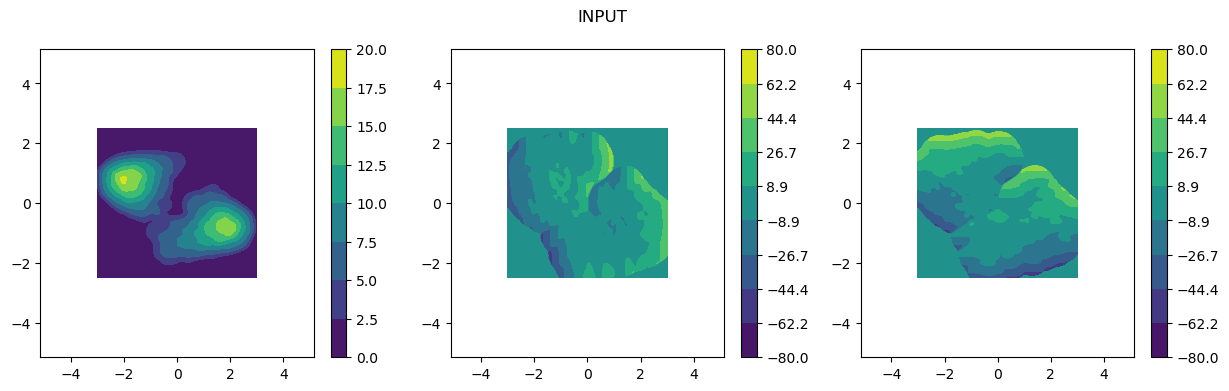

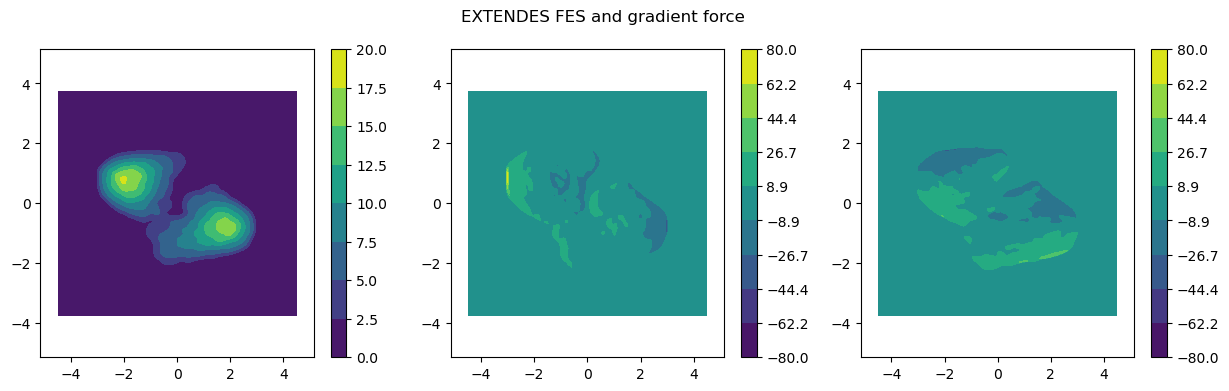

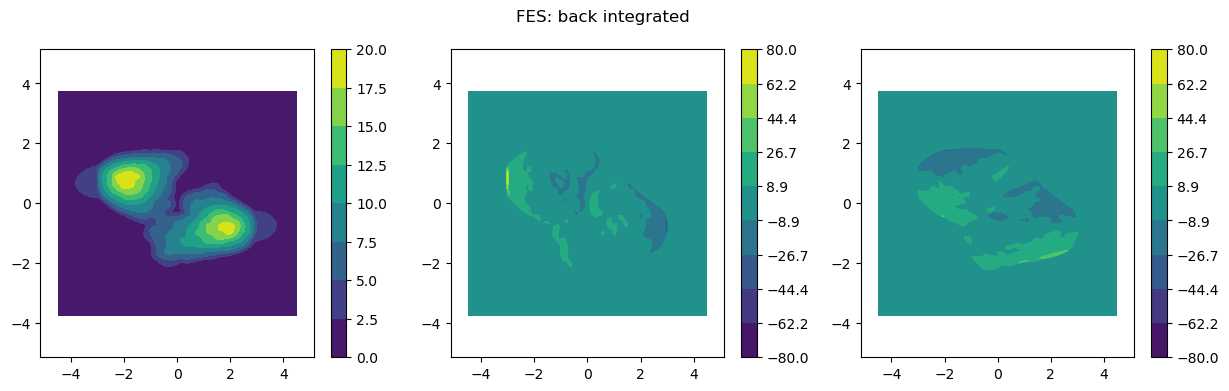

In [7]:
# grid_x = np.linspace(-10, 10, 12); 
# grid_y = np.linspace(20, 40, 10); 
# X, Y = np.meshgrid(grid_x, grid_y)

[F_ext_x, F_ext_y] = make_external_bias_2D(X,Y, FES_1, Ftot_x_1, Ftot_y_1, FES_lim=18)
# [F_ext_x, F_ext_y] = make_external_bias_2D(X,Y, np.zeros_like(X), np.zeros_like(X), np.zeros_like(X), FES_lim=18)


Running simulation...
(400, 200)
|**************************************************| 100% | Average Mean Force Error: 10.081

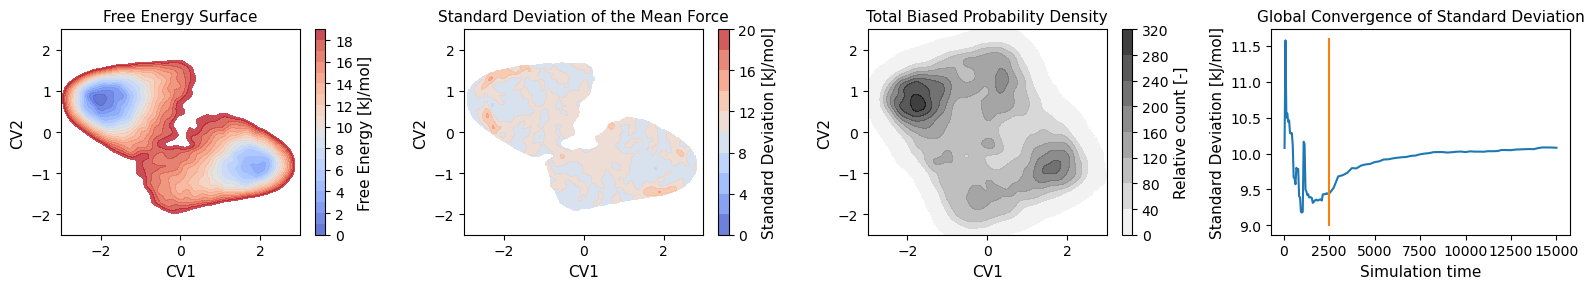

In [19]:
ofe_history_patch = ofe_history_1[:]
volume_history_patch = volume_history_1[:]
time_history_patch = time_history_1[:]


# Run simulation
# run_plumed.run_2D_Invernizzi(simulation_steps=5000000, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=-1, initial_position_y=-1, file_extension="inv_pot", external_bias_file="external_bias2.dat")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_inv_pot")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="positioninve_inv_pot")



#COMPUTE Mean force and weight of the simulation
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(
    HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((0.12,0.12)), kT = 1, nhills=int(len(HILLS)/2),
    min_grid=np.array((-3, -2.5)), max_grid=np.array((3, 2.5)), nbins=np.array((200,400)), error_pace = int(len(HILLS)/100), base_terms=[Ftot_den_1, Ftot_den2_1, Ftot_x_1, Ftot_y_1, ofv_num_x_1, ofv_num_y_1] , FES_cutoff = 20, F_static_x=-F_ext_x, F_static_y=-F_ext_y)


ofe_history_patch += ofe_history
volume_history_patch += volume_history
time_history_patch += [element+time_history_1[-1] for element in time_history]

[Ftot_den_patch, Ftot_x_patch, Ftot_y_patch, ofv, ofe] = MFI.patch_to_base_variance([Ftot_den_1, Ftot_den2_1, Ftot_x_1, Ftot_y_1, ofv_num_x_1, ofv_num_y_1], [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
cutoff = MFI.get_cutoff(Ftot_den=Ftot_den_patch, FX=Ftot_x_patch, FY=Ftot_y_patch, FES_cutoff=20)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x_patch, Ftot_y_patch, min_grid=np.array((-3, -2.5)), max_grid=np.array((3, 2.5)))

cutoff = np.where(FES <= np.ones_like(FES) * 18, 1, 0)

#Plot results
MFI.plot_recap_2D(X, Y, FES, MFI.zero_to_nan(np.where(Ftot_den_patch > 0.1, Ftot_den_patch, 0)), MFI.zero_to_nan(ofe*cutoff), ofe_history_patch, time_history_patch, FES_lim=20, ofe_map_lim=21, FES_step=1, ofe_step=2)
plt.plot([2500,2500], [9,11.6])
plt.show()

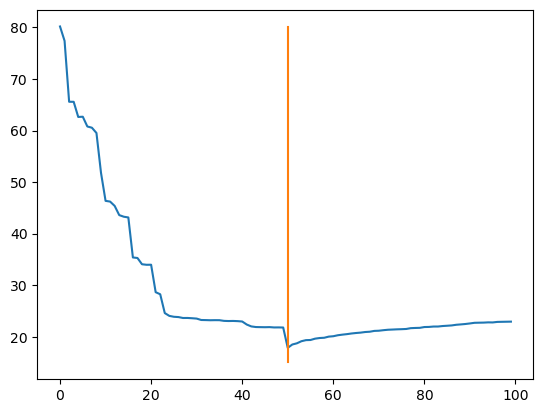

In [20]:
plt.plot(range(len(ofe_history_patch)), np.asarray(ofe_history_patch) / np.asarray(volume_history_patch))
plt.plot([50,50], [15,80])


AAD_1: 2.159853027903132
AAD: 1.5081581797265067


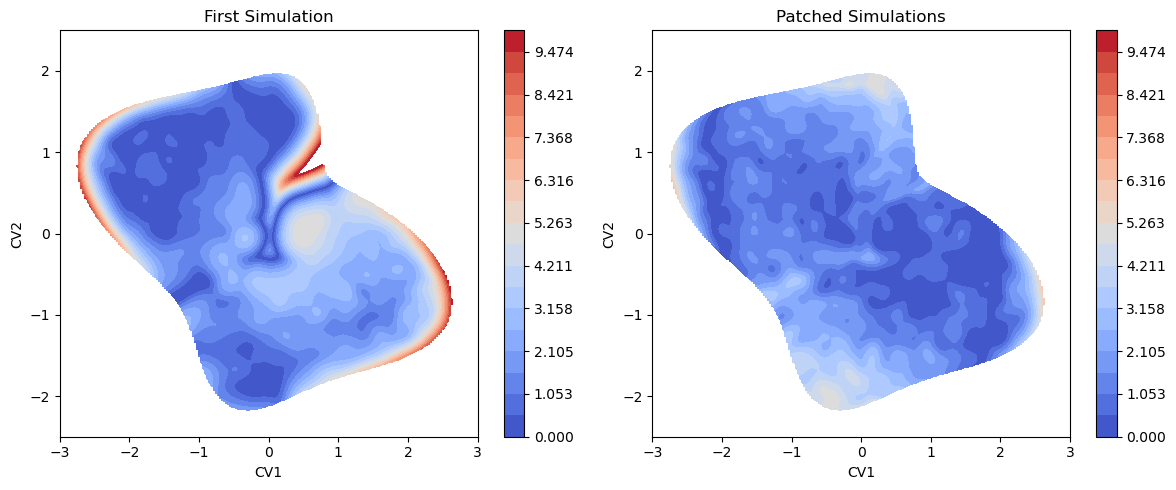

In [21]:
AD_1 = abs(inve_pot - FES_1) 
AD_1 = np.where(inve_pot < 19, AD_1, 0)
AAD_1 = np.sum(AD_1)/(np.count_nonzero(AD_1))
print("AAD_1:", AAD_1)

AD = abs(inve_pot - FES) 
AD = np.where(inve_pot < 19, AD, 0)
AAD = np.sum(AD)/(np.count_nonzero(AD))
print("AAD:", AAD)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.contourf(X,Y,MFI.zero_to_nan(AD_1), cmap="coolwarm", levels=np.linspace(0,10,20))
plt.title("First Simulation"); plt.xlabel("CV1"); plt.ylabel("CV2"); plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(X,Y,MFI.zero_to_nan(AD), cmap="coolwarm", levels=np.linspace(0,10,20))
plt.title("Patched Simulations"); plt.xlabel("CV1"); plt.ylabel("CV2"); plt.colorbar()

plt.tight_layout()
plt.show()


(400, 200)
(400, 200)
(400, 200)
AAD_1: 2.159853027903132
AAD: 1.4106188993808082


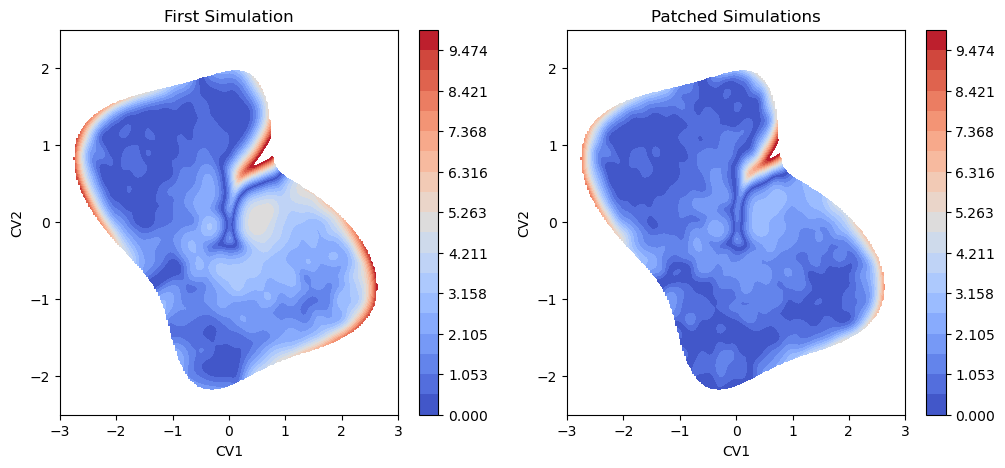

In [14]:
AD_1 = abs(inve_pot - FES_1) 
AD_1 = np.where(inve_pot < 19, AD_1, 0)
AAD_1 = np.sum(AD_1)/(np.count_nonzero(AD_1))
print("AAD_1:", AAD_1)

AD = abs(inve_pot - FES) 
AD = np.where(inve_pot < 19, AD, 0)
AAD = np.sum(AD)/(np.count_nonzero(AD))
print("AAD:", AAD)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.contourf(X,Y,MFI.zero_to_nan(AD_1), cmap="coolwarm", levels=np.linspace(0,10,20))
plt.title("First Simulation"); plt.xlabel("CV1"); plt.ylabel("CV2"); plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(X,Y,MFI.zero_to_nan(AD), cmap="coolwarm", levels=np.linspace(0,10,20))
plt.title("Patched Simulations"); plt.xlabel("CV1"); plt.ylabel("CV2"); plt.colorbar()

plt.show()


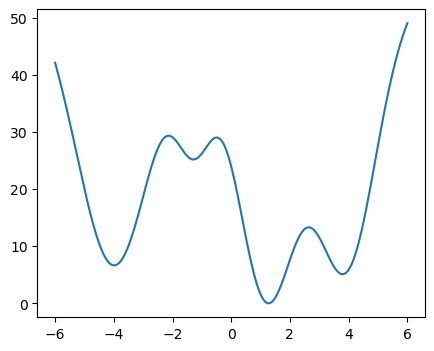

In [2]:
min_grid = -6
max_grid = 6
nbins = 401
grid = np.linspace(min_grid, max_grid, nbins)
y = - 45*np.exp(-0.5 * (((grid + 4.0) ** 2) / 1.5)) - 20*np.exp(-0.5 * (((grid + 1.26) ** 2) / 0.4)) - 50*np.exp(-0.5 * (((grid - 1.2) ** 2) / 1.0)) - 45*np.exp(-0.5 * (((grid - 3.9) ** 2) / 1.0)) + np.exp(-grid-5) + np.exp(grid-5)
y_string = "-45*exp(-0.5/1.5*(x+4.0)^2)-20*exp(-0.5/0.4*(x+1.26)^2)-50*exp(-0.5*(x-1.2)^2)-45*exp(-0.5*(x-3.9)^2)+exp(-x-5)^2+exp(x-5)"
y = y - min(y)

plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.show()

#Define constants 
bw = 0.05; bw2 = bw**2     
kT = 2.49 
n_steps = 100_000    
master = []    

### 1st simulation

In [3]:
master = []

#Run simuation
# plumed.run_langevin1D(n_steps, analytical_function = y_string, initial_position=-4.0,  gaus_width=0.1, gaus_height=5, biasfactor=10, grid_min=-8.0, grid_max=8.0, grid_bin=400)
# try: os.system("rm bck.*")
# except: pass

#Load HILLS and position file
HILLS=MFI1D.load_HILLS(hills_name="HILLS1")
position = MFI1D.load_position(position_name="position1")

#Run MFI algorithm to find force terms
results = MFI1D.MFI_1D( HILLS=HILLS, position=position, bw=0.1, min_grid=min_grid, max_grid=max_grid, nbins=nbins, log_pace=1, error_pace=200)
grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results

#save results to master
master.append([Ftot_den, Ftot_den2, Ftot, ofv_num])
        
#Patch master
[X, PD_patch, F_patch, FES, AD, AAD, OFE, AOFE] = MFI1D.patch_FES_AD_ofe(master, grid, y, nbins)

Ftot_ext = Ftot

/home/ucecabj/Desktop/MFI_development/external_bias/MFI1D.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dfds = np.where(pb_t < Ftot_den_limit, 0, Fpbt / pb_t) + Fbias - F_static
/home/ucecabj/Desktop/MFI_development/external_bias/MFI1D.py:323: RuntimeWarning: invalid value encountered in true_divide
  dfds = np.where(pb_t < Ftot_den_limit, 0, Fpbt / pb_t) + Fbias - F_static
/home/ucecabj/Desktop/MFI_development/external_bias/MFI1D.py:325: RuntimeWarning: invalid value encountered in true_divide
  Ftot = np.where(Ftot_den > Ftot_den_limit, Ftot_num / Ftot_den, 0)
/home/ucecabj/Desktop/MFI_development/external_bias/MFI1D.py:344: RuntimeWarning: invalid value encountered in true_divide
  ofv = np.where(Ftot_den > Ftot_den_limit, ofv_num / Ftot_den, 0) - np.square(Ftot)
/home/ucecabj/Desktop/MFI_development/external_bias/MFI1D.py:346: RuntimeWarning: divide by zero encountered in true_divide
  ofv *= np.where(temp_diff > 0, np.square(Ftot_den) / temp_diff, 0)
/home/uc

100.0 %   OFE = 12.5785


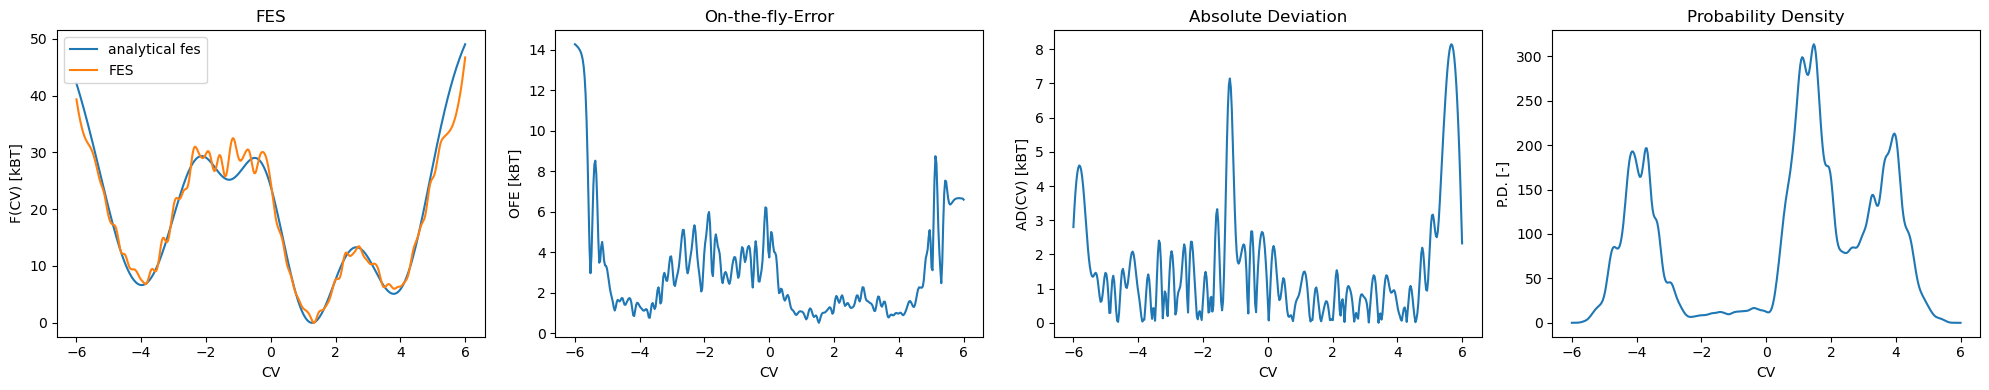

In [4]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot(grid, y, label="analytical fes"); plt.plot(grid, FES, label="FES"); plt.title("FES"); plt.xlabel("CV"); plt.ylabel("F(CV) [kBT]"); plt.legend()

plt.subplot(1,4,2)
plt.plot(grid, OFE); plt.title("On-the-fly-Error"); plt.xlabel("CV"); plt.ylabel("OFE [kBT]")

plt.subplot(1,4,3)
plt.plot(grid, AD); plt.title("Absolute Deviation"); plt.xlabel("CV"); plt.ylabel("AD(CV) [kBT]")

plt.subplot(1,4,4)
plt.plot(grid, PD_patch); plt.title("Probability Density"); plt.xlabel("CV"); plt.ylabel("P.D. [-]")

plt.tight_layout(); plt.show()

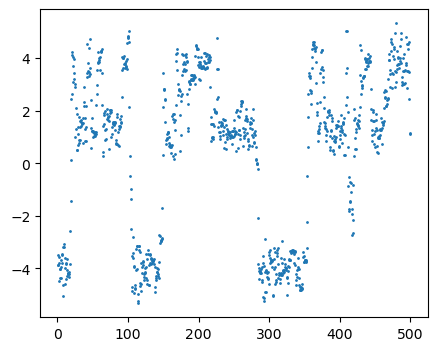

In [5]:
HILLS=MFI1D.load_HILLS(hills_name="HILLS1")
plt.figure(figsize=(5,4)); plt.scatter(HILLS[:,0], HILLS[:,1], s=1)

### Save FES as bias for next simulation

first column grid

second column energy 

third column force (derivative of enery)

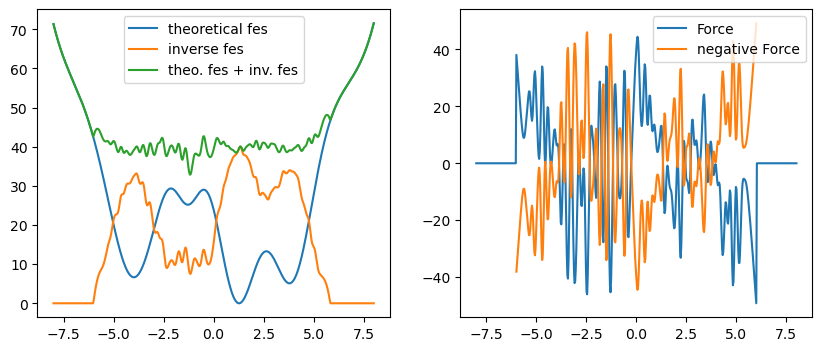

In [7]:
#Save transpose of [grid_p, FES_long, Ftot_long] defined on the same grid that plumed is using

# def make_external_bias_file(grid_old, FES, Ftot, grid_min_plumed, grid_max_plumed, nbins_plumed, FES_cutoff, file_name_extension=""):
    
#     #define plumed grid (so that plumed can explore values outside of shorter grid defined above)
#     grid_plumed = np.linspace(grid_min_plumed, grid_max_plumed, nbins_plumed)
    
#     #Interpolate FES onto plumed grid
#     FES_plumed = np.interp(grid_plumed, grid_old, FES)
#     FES_plumed = np.where(FES_plumed > FES_cutoff, FES_cutoff, FES_plumed)
#     FES_plumed = -FES_plumed + FES_cutoff   
    
#     #Interpolate Force on long grid
#     Ftot_plumed = np.interp(grid_plumed, grid_old, -Ftot)

#     #Do transpose 
#     external_bias_vector = np.array([grid_plumed, FES_plumed, Ftot_plumed]).T
    
#     with open("external_biFES_plumedas.dat" + file_name_extension, "w") as f:
#         #Write some information for plumed
#         f.write("#! FIELDS p.x external.bias der_p.x\n")
#         f.write("#! SET min_p.x {}\n".format(grid_min_plumed))
#         f.write("#! SET max_p.x {}\n".format(grid_max_plumed))
#         f.write("#! SET nbins_p.x {}\n".format(nbins_plumed-1))
#         f.write("#! SET periodic_p.x false\n")
    
#         #Save array to external_bias.dat file 
#         np.savetxt("external_bias.dat" + file_name_extension , external_bias_vector, fmt="%.8f", delimiter="   ")
        

def make_external_bias(grid_old, FES, Ftot, grid_min_plumed, grid_max_plumed, FES_cutoff, file_name_extension=""):
    
    #create extended grid so that it goes to reaches grid_min_plumed and grid_max_plumed
    grid_spacing = grid_old[1] - grid_old[0]
    lower_new_values = int((grid_old[0] - grid_min_plumed)/grid_spacing) + 1
    upper_new_values = int((grid_max_plumed - grid_old[-1])/grid_spacing) + 1
    new_end_values = (grid_old[0] - grid_spacing*lower_new_values, grid_old[-1] + grid_spacing*upper_new_values) 
       
    grid_plumed = np.pad(grid_old, (lower_new_values, upper_new_values), mode="linear_ramp", end_values=new_end_values)
    nbins_plumed = len(grid_plumed)
    
    #Extend FES and Ftot using constant values
    FES_plumed = np.where(FES > FES_cutoff, FES_cutoff, FES)
    FES_plumed = np.pad(FES_plumed, (lower_new_values, upper_new_values), mode="constant", constant_values=FES_cutoff)
    FES_plumed = -FES_plumed + FES_cutoff   
    Ftot_plumed = np.pad(-Ftot, (lower_new_values, upper_new_values), mode="constant")
    
    #Save to external_bias.dat file
    head_text = "#! FIELDS p.x external.bias der_p.x\n#! SET min_p.x " + str(grid_min_plumed) + "\n#! SET max_p.x " + str(grid_max_plumed) + "\n#! SET nbins_p.x " + str(nbins_plumed-1) + "\n#! SET periodic_p.x false"
    external_bias_vector = np.array([grid_plumed, FES_plumed, Ftot_plumed]).T       
    np.savetxt("external_bias.dat" + file_name_extension , external_bias_vector, fmt="%.8f", delimiter="   ", header=head_text, comments="")

    return [grid_plumed, FES_plumed, Ftot_plumed]
    
    
    
# make_external_bias_file(grid_old=grid, FES=FES, Ftot=Ftot, grid_min_plumed=-8, grid_max_plumed=8, nbins_plumed=501, FES_cutoff=40)    

[grid_plumed, FES_plumed, Ftot_plumed] = make_external_bias(grid, FES, Ftot, grid_min_plumed=-8, grid_max_plumed=8, FES_cutoff=40)

#plot results
y_plumed = - 45*np.exp(-0.5 * (((grid_plumed + 4.0) ** 2) / 1.5)) - 20*np.exp(-0.5 * (((grid_plumed + 1.26) ** 2) / 0.4)) - 50*np.exp(-0.5 * (((grid_plumed - 1.2) ** 2) / 1.0)) - 45*np.exp(-0.5 * (((grid_plumed - 3.9) ** 2) / 1.0)) + np.exp(-grid_plumed-5) + np.exp(grid_plumed-5)
y_plumed = y_plumed - min(y_plumed)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(grid_plumed, y_plumed, label="theoretical fes")
plt.plot(grid_plumed, FES_plumed, label="inverse fes")
plt.plot(grid_plumed, FES_plumed + y_plumed, label="theo. fes + inv. fes")
plt.legend()

plt.subplot(1,2,2)
plt.plot(grid_plumed, Ftot_plumed, label="Force")
plt.plot(grid, Ftot, label="negative Force")
plt.legend(); plt.show()

### Run 2nd simulation with external bias

In [10]:
def run_langevin1D_external(simulation_steps,
                   analytical_function = "7*x^4-23*x^2", periodic= "NO",
                   initial_position=0.0, temperature=1, time_step=0.005,
                   grid_min=-3.0, grid_max=3.0, grid_bin=200,
                   gaus_width=0.1, gaus_height=1, biasfactor=10, gaus_pace=100, position_pace=0,
                   hp_centre=0.0, hp_kappa=0,
                   lw_centre=0.0, lw_kappa=0,
                   uw_centre=0.0, uw_kappa=0,
                   external_bias_file=""):
    """Function to run a langevin simulation in 1 dimension. Default analytical potential: y = 7*x^4-23*x^2.

    Args:
        simulation_steps (int): Number of steps in simulation
        analytical_function (str, optional): The analytical function to be analysed. Defaults to "7*x^4-23*x^2".
        periodic_boundaries (str, optional): Information wheather boundary conditions are periodic ("ON") or not ("NO"). Defaults to "NO".
        initial_position (float, optional): Initial position of simulation. Defaults to 0.0.
        temperature (int, optional): Temperature of simulation (units in kT). Defaults to 1.
        time_step (float, optional): Length of one time step (units in ps). Defaults to 0.005.
        grid_min (float, optional): Minimum value of grid where the bias is stored. Defaults to -3.0.
        grid_max (float, optional): Maximum value of grid where the bias is stored. Defaults to 3.0.
        grid_bin (int, optional): Number of distinct bins in grid. Defaults to 200.
        gaus_width (float, optional): Gaussian width (sigma) of metadynamics bias. Defaults to 0.1.
        gaus_height (int, optional): Gaussian height of metadynamics bias. Defaults to 1.
        biasfactor (int, optional): Biasfactor of metadynamics bias. Defaults to 10.
        gaus_pace (in t, optional): Pace of deposition of metadynamics hills. Defaults to 100.
        position_pace (int, optional): Pace of recording the CV in the position file. When position_pace=0, position_pace = gaus_pace/10. Defaults to 0.
        hp_centre (float, optional): position of harmonic potential. Defaults to 0.0.
        hp_kappa (int, optional): force_constant of harmonic potential. Defaults to 0.
        lw_centre (float, optional): position of lower wall potential. Defaults to 0.0.
        lw_kappa (int, optional): force_constant of lower wall potential. Defaults to 0.
        uw_centre (float, optional): position of upper wall potential. Defaults to 0.0.
        uw_kappa (int, optional): force_constant of upper wall potential. Defaults to 0.
    """


    if periodic == "YES":
        periodic_boundaries = str(grid_min) + "," + str(grid_max)
    elif periodic == "NO":
        periodic_boundaries = "NO"
    else:
        print("Please specify if you want to use periodic boundaries using \"YES\" or \"NO\". \nFor now, no periodic boundaries are assumed")
        periodic_boundaries = "NO"
        grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results

        
    with open("input" ,"w") as f:
        print("""temperature {}
tstep {}
friction 1
dimension 1
nstep {}
ipos {}""".format(temperature, time_step, simulation_steps,  initial_position) ,file=f)

        if periodic_boundaries == "NO":
            f.write("periodic false")
        else:
            f.write("periodic on ")
            f.write("min {} ".format(grid_min))
            f.write("max {}".format(grid_max))


    with open("plumed.dat" ,"w") as f:
        print("""p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ARG=p.x FUNC=({}) PERIODIC={}
bb: BIASVALUE ARG=ff""".format(analytical_function, periodic_boundaries) ,file=f)

    with open("plumed.dat" ,"a") as f:
        # Metadynamics bias. To activate, the height of the bias needs to be a positive number.
        if gaus_height > 0:
            f.write("METAD ARG=p.x SIGMA={} HEIGHT={} BIASFACTOR={} GRID_MIN={} GRID_MAX={} GRID_BIN={} PACE={} \
TEMP={} \n".format(gaus_width, gaus_height, biasfactor, grid_min, grid_max, grid_bin, gaus_pace, temperature * 120))

        # Harmonic potential bias. To activate, the force constant (kappa) needs to be a positive number
        if hp_kappa > 0:
            f.write("RESTRAINT ARG=p.x AT={} KAPPA={} LABEL=restraint \n".format(hp_centre, hp_kappa))

        # Lower wall bias. To activate, the force constant (kappa) needs to be a positive number
        if lw_kappa > 0:
            f.write("LOWER_WALLS ARG=p.x AT={} KAPPA={} LABEL=lowerwall \n".format(lw_centre, lw_kappa))

        # Upper wall bias. To activate, the force constant (kappa) needs to be a positive number
        if uw_kappa > 0:
            f.write("UPPER_WALLS ARG=p.x AT={} KAPPA={} LABEL=upperwall \n".format(uw_centre, uw_kappa))
            
        if external_bias_file != "":
            f.write("EXTERNAL ARG=p.x FILE={} LABEL=external \n".format(external_bias_file))

        # Print position of system. If position_pace = 0, it will be position_pace = gaus_pace/10
        if position_pace == 0: position_pace = int(gaus_pace / 10)
        f.write("PRINT FILE=position ARG=p.x STRIDE={}".format(position_pace))


    os.system("plumed pesmd < input >/dev/null 2>&1")

In [15]:
#Run metaD simulation with external bias
run_langevin1D_external(n_steps, analytical_function = y_string, initial_position=4.0,  gaus_width=0.1, gaus_height=5, biasfactor=10, grid_min=-8.0, grid_max=8.0, grid_bin=400, external_bias_file="external_bias.dat")
try: os.system("rm bck.*")
except: pass

#Load HILLS and position file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")
position = MFI1D.load_position(position_name="position")

#Run MFI algorithm
results = MFI1D.MFI_1D( HILLS=HILLS, position=position, bw=0.1, min_grid=min_grid, max_grid=max_grid, nbins=nbins, log_pace=1, error_pace=200, F_static=-Ftot_ext)


grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results


#save results to master
master.append([Ftot_den, Ftot_den2, Ftot, ofv_num])
        
#Patch master
[X, PD_patch, F_patch, FES, AD, AAD, OFE, AOFE] = MFI1D.patch_FES_AD_ofe(master, grid, y, nbins)

100.0 %   OFE = 14.0301


rm: cannot remove 'bck.*': No such file or directory


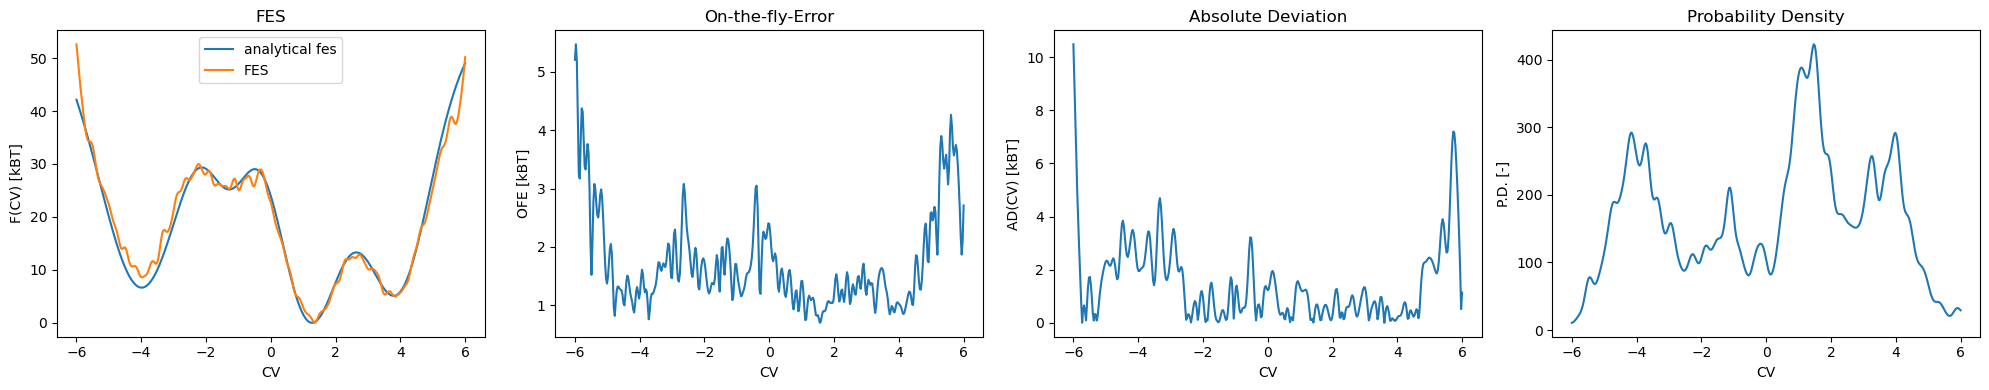

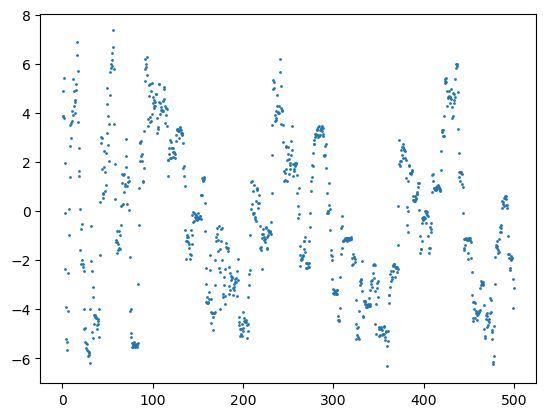

In [16]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot(grid, y, label="analytical fes"); plt.plot(grid, FES, label="FES"); plt.title("FES"); plt.xlabel("CV"); plt.ylabel("F(CV) [kBT]"); plt.legend()

plt.subplot(1,4,2)
plt.plot(grid, OFE); plt.title("On-the-fly-Error"); plt.xlabel("CV"); plt.ylabel("OFE [kBT]")

plt.subplot(1,4,3)
plt.plot(grid, AD); plt.title("Absolute Deviation"); plt.xlabel("CV"); plt.ylabel("AD(CV) [kBT]")

plt.subplot(1,4,4)
plt.plot(grid, PD_patch); plt.title("Probability Density"); plt.xlabel("CV"); plt.ylabel("P.D. [-]")

plt.tight_layout(); plt.show()

HILLS=MFI1D.load_HILLS(hills_name="HILLS")
plt.scatter(HILLS[:,0], HILLS[:,1], s=1); plt.show();


In [14]:
print(np.shape(master))

(1, 4, 401)


### Comparison with just one long simulation

100.0 %   OFE = 12.4579


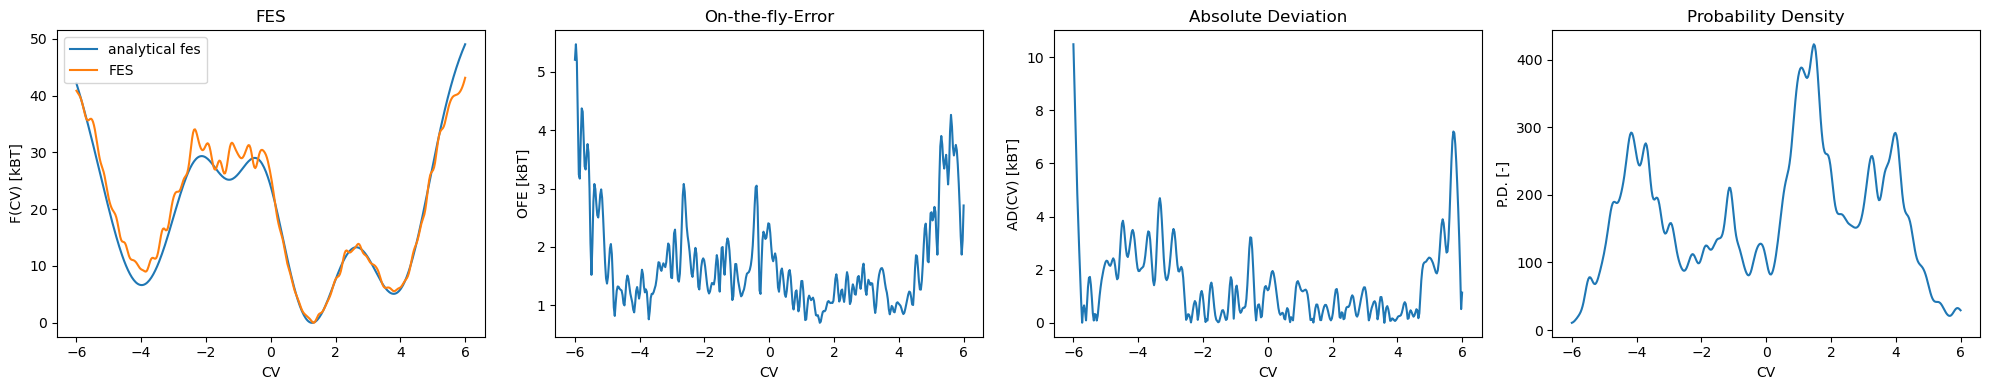

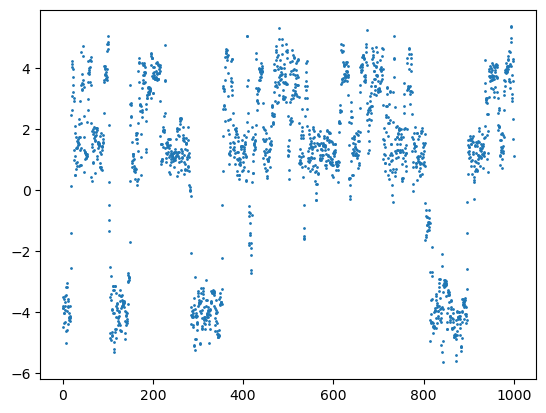

In [20]:
# #Run simuation
# plumed.run_langevin1D(int(n_steps*2), analytical_function = y_string, initial_position=-4.0,  gaus_width=0.1, gaus_height=5, biasfactor=10, grid_min=-8.0, grid_max=8.0, grid_bin=400)
# try: os.system("rm bck.*")
# except: pass

#Load HILLS and position file
HILLS=MFI1D.load_HILLS(hills_name="HILLS2")
position = MFI1D.load_position(position_name="position2")

#Run MFI algorithm to find force terms
results = MFI1D.MFI_1D( HILLS=HILLS, position=position, bw=0.1, min_grid=min_grid, max_grid=max_grid, nbins=nbins, log_pace=1, error_pace=200)
grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results


for _ in [1]:
    plt.figure(figsize=(20,4))
    plt.subplot(1,4,1)
    plt.plot(grid, y, label="analytical fes"); plt.plot(grid, FES, label="FES"); plt.title("FES"); plt.xlabel("CV"); plt.ylabel("F(CV) [kBT]"); plt.legend()

    plt.subplot(1,4,2)
    plt.plot(grid, OFE); plt.title("On-the-fly-Error"); plt.xlabel("CV"); plt.ylabel("OFE [kBT]")

    plt.subplot(1,4,3)
    plt.plot(grid, AD); plt.title("Absolute Deviation"); plt.xlabel("CV"); plt.ylabel("AD(CV) [kBT]")

    plt.subplot(1,4,4)
    plt.plot(grid, PD_patch); plt.title("Probability Density"); plt.xlabel("CV"); plt.ylabel("P.D. [-]")

    plt.tight_layout(); plt.show()

    HILLS=MFI1D.load_HILLS(hills_name="HILLS2")
    plt.scatter(HILLS[:,0], HILLS[:,1], s=1); plt.show();